In [233]:
import gc
gc.collect()

49391

In [234]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 8.6 gigabytes of available RAM

Not using a high-RAM runtime


In [235]:
#Imports
import os
import numpy as np
import tensorflow as tf
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import math
from keras.layers import *
from keras.models import *
from keras.losses import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from keras.models import load_model
from PIL import Image
import heapq

# Step 1: Loading in the data

In [236]:
#Read in data
csvFilePath="/Users/esmasert/Desktop/LungProject/PadChestFixedSmall.csv"
df = pd.read_csv(csvFilePath)
df.fillna(method = 'ffill',inplace = True)

In [237]:
len(df)

14

In [238]:
len(df['image_list'][0])

728648

In [239]:
#Transform the data into images and plot one to see

imgs = []
for i in range(0,len(df)):

    img = df['image_list'][i].split()
    img = ['0' if x == '' else x for x in img]
    imgs.append(img)


In [240]:
len(imgs)

14

In [241]:
image_list = np.array(imgs,dtype = 'float')
image_list.shape

(14, 262144)

In [242]:
X_train = image_list.reshape(-1,512,512,1)
X_train.shape

(14, 512, 512, 1)

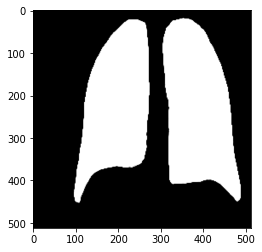

In [243]:
plt.imshow(X_train[0].reshape(512,512),cmap='gray')
plt.show()

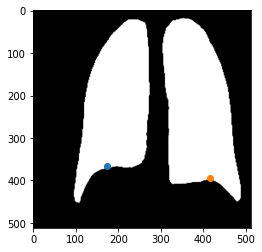

In [244]:
#Get the keypoint labels
training = df.drop('image_list',axis = 1)

y_train = []
for i in range(0,len(df)):
    y = training.iloc[i,:]

    y_train.append(y)
y_train = np.array(y_train,dtype = 'float')

#Plot labels ontop of image
img = X_train[0].copy()
for i in range(0, len(y_train[0])-1, 2):
    x = int(y_train[0][i])
    y = int(y_train[0][i+1])
    plt.scatter(x,y)
plt.imshow(img.reshape(512,512),cmap='gray')

In [245]:
print(X_train.shape)
print(y_train.shape)

(14, 512, 512, 1)
(14, 4)


# Step 2: Creating the Heatmaps

In [ ]:
#Read in data
csvFilePath="/data/PadChestFixedSmall.csv"
df = pd.read_csv(csvFilePath)
df.fillna(method = 'ffill',inplace = True)

print(len(df))

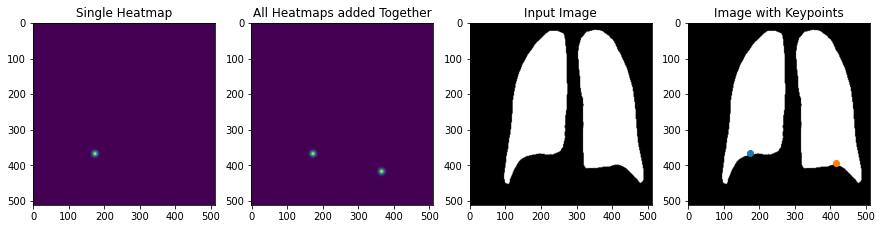

(2, 512, 512)

In [247]:
#Generate heatmaps for one sample image
heatmaps = []

for i in range(0, 2, 1):
    x = int(y_train[0][i])
    y = int(y_train[0][i + 1])
    heatmap = gaussian(x, y, 512, 512)
    heatmaps.append(heatmap)

heatmaps = np.array(heatmaps)

plt.figure(figsize=(15,15))

plt.subplot(1,4,1)
plt.imshow(heatmaps[0])
plt.title("Single Heatmap")

plt.subplot(1,4,2)
plt.imshow(heatmaps.sum(axis=0))
plt.title("All Heatmaps added Together")

plt.subplot(1,4,3)
plt.imshow(np.squeeze(X_train[0], axis=2), cmap='gray')
plt.title("Input Image")

plt.subplot(1,4,4)
for i in range(0, len(y_train[0])-1, 2):
    x = int(y_train[0][i])
    y = int(y_train[0][i+1])
    plt.scatter(x,y)
plt.imshow(X_train[0].reshape(512,512), cmap='gray')
plt.title("Image with Keypoints")
plt.show()

heatmaps.shape

# Step 3: Keras Custom Generator

In [290]:
class DataGenerator(tf.keras.utils.Sequence):

    def __init__(self, imgs, kps, batch_size=1, shuffle=True):
        self.imgs = imgs
        self.kps = kps
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return len(self.imgs) // self.batch_size

    def __getitem__(self, index):
        #Get index of images to generate
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X, y = self.__data_generation(indexes)

        return X, y

    def on_epoch_end(self):
        #Shuffle the data after the generator has run through all samples
        self.indexes = np.arange(len(self.imgs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def gaussian(self, xL, yL, H, W, sigma=5):
        ##Function that creates the heatmaps##
        channel = [math.exp(-((c - xL) ** 2 + (r - yL) ** 2) / (2 * sigma ** 2)) for r in range(H) for c in range(W)]
        channel = np.array(channel, dtype=np.float32)
        channel = np.reshape(channel, newshape=(H, W))

        return channel

    def __data_generation(self, indexes):
        'Generates data containing batch_size samples'
        X_batch = [self.imgs[i] for i in indexes]
        X_batch = np.array(X_batch)

        y_batch = []

        kps = [self.kps[i] for i in indexes]

        for i in range(0,len(kps)):
            heatmaps = []
            for j in range(0, 2):
                x = int(kps[i][j*2])
                y = int(kps[i][j*2+1])
                heatmap = self.gaussian(x, y, 512, 512)
                heatmaps.append(heatmap)
            y_batch.append(heatmaps)

        y_batch = np.array(y_batch)
        y_batch = np.swapaxes(y_batch,1,3)
        y_batch = np.swapaxes(y_batch,1,2)
        return X_batch, [y_batch, y_batch]

(1, 512, 512, 1)
(1, 512, 512, 2)


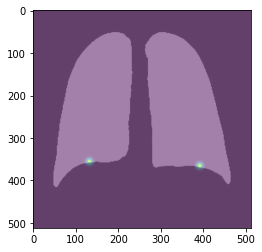

In [291]:
#Testing to see if our DataGenerator is working
X_batch, [y_batch, _] = next(DataGenerator(X_train, y_train).__iter__())
print(X_batch.shape)
print(y_batch.shape)

#Plot a single image overlayed with its heatmaps
plt.imshow(X_batch[0].reshape(512,512), cmap='gray', alpha=0.5)
plt.imshow(y_batch[0].sum(axis=2), alpha=0.5)

# Testing The Model

In [ ]:
model = load_model('/data/HeatMap/testCkpt.hdf5')
#model.summary()

1/1 [==============================] - 4s 4s/step


Text(0.5, 1.0, 'Stage 2 Prediction')

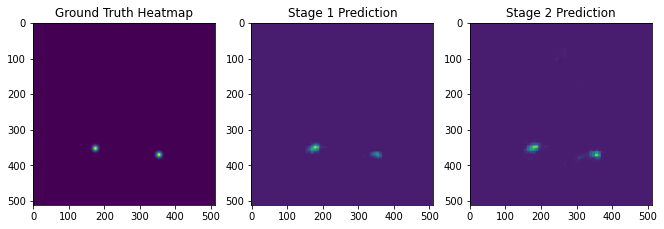

In [293]:
#First, lets split the data into training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

#Create your two generators for train and validation
gen_train = DataGenerator(X_train, y_train)
gen_val = DataGenerator(X_val, y_val)

X_batch, [y_batch, _] = next(gen_val.__iter__())

index = np.random.randint(0,1)

predictions = model.predict(X_batch)

plt.figure(figsize=(15,15))
plt.subplot(1,4,1)
plt.imshow(y_batch[index].sum(axis=2))
plt.title("Ground Truth Heatmap")

plt.subplot(1,4,2)
plt.imshow(predictions[0][index].sum(axis=2))
plt.title("Stage 1 Prediction")

plt.subplot(1,4,3)
plt.imshow(predictions[1][index].sum(axis=2))
plt.title("Stage 2 Prediction")

In [294]:
predictions[1][index].shape

(512, 512, 2)

In [295]:
resultImage= predictions[1][index].sum(axis=2)

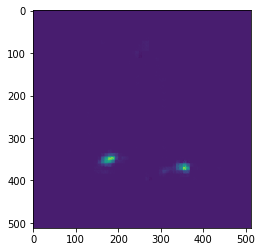

In [296]:
plt.imshow(resultImage)

In [ ]:
filename= "/data/HeatMap/resultHeatMap.png"
cv2.imwrite(filename, resultImage)

True

In [298]:
predictions[1][index].shape

(512, 512, 2)

In [299]:
resultImage.shape

(512, 512)

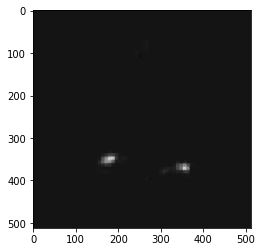

In [300]:
plt.imshow(resultImage, cmap='gray')

# Display the plot
plt.show()

In [ ]:
plt.imsave('/data/HeatMap/resultHeatMap_gray.jpg', resultImage, cmap='gray')

In [302]:
pre=resultImage[0][0]
count=0
for i in resultImage:
    for j in i:
        if j!= resultImage[0][0]:
            #pre = j
            #print(j)
            count+=1
print(count)

10777


(512, 512, 3)


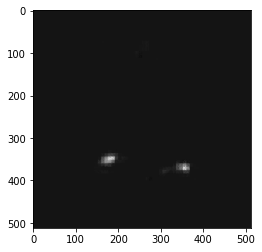

In [ ]:
import cv2 
import numpy as np

image = cv2.imread("/data/HeatMap/resultHeatMap_gray.jpg")

print(image.shape)

plt.imshow(image)


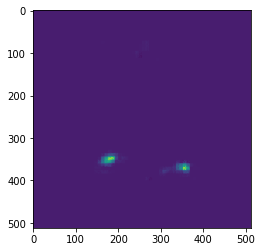

In [304]:
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_image)

In [305]:
gray_image.shape

(512, 512)

## Slide Windows

In [306]:
def sliding_window(image, stepSize, windowSize):
    windowAreaList=[]
    windowArea=0
    
    for x in range(0, image.shape[0]-windowSize, stepSize):
        for y in range(0, image.shape[1]-windowSize, stepSize):
            windowArea =0
            for num1 in range(0,windowSize):
                for num2 in range(0,windowSize):
                    #print(image[x+num1][y+num2])
                    windowArea+=image[x+num1][y+num2]
                    
            temp=[]
            temp.append(windowArea)
            temp.append(x)
            temp.append(y)
            
            windowAreaList.append(temp)
            
    return windowAreaList
            
            
windows = sliding_window(gray_image, 15, 16)


In [307]:
len(windows)

1156

In [308]:
justWindowAreas=[]

for i in windows:
    justWindowAreas.append(i[0])

In [309]:
largest2nums = heapq.nlargest(2, enumerate(justWindowAreas), key=lambda x: x[1])

In [310]:
largest2nums

[(793, 34003), (839, 33683)]

In [311]:
print(windows[largest2nums[0][0]])
print(windows[largest2nums[1][0]])

[34003, 345, 165]
[33683, 360, 345]


In [312]:
point1=windows[largest2nums[0][0]][2],windows[largest2nums[0][0]][1]
point2=windows[largest2nums[1][0]][2],windows[largest2nums[1][0]][1]

In [313]:
print(point1,point2)

(165, 345) (345, 360)


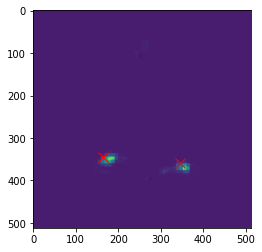

In [314]:
plt.imshow(gray_image)
#plt.scatter(point1, point2, marker="x", color="red")
plt.plot(point1[0], point1[1], "x", markersize=10, color="red")  # og:shorthand for green circle
plt.plot(point2[0], point2[1], "x", markersize=10, color="red")  # og:shorthand for green circle
plt.show()

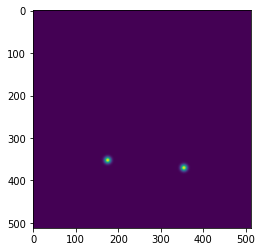

In [315]:
plt.imshow(y_batch[index].sum(axis=2))

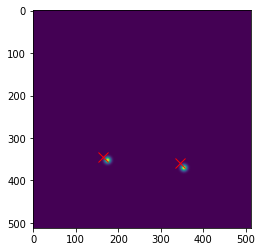

In [316]:
gtImage= y_batch[index].sum(axis=2)
plt.imshow(gtImage)
#plt.scatter(point1, point2, marker="x", color="red")
plt.plot(point1[0], point1[1], "x", markersize=10, color="red")  # og:shorthand for green circle
plt.plot(point2[0], point2[1], "x", markersize=10, color="red")  # og:shorthand for green circle
plt.show()